# 2.0 Exploratory Data Analysis

**Objective:** The primary goal of this notebook is to transition from raw audio features to interpretable psychological insights. We aim to understand how physical sound properties (frequency, amplitude, rhythm) translate into human emotional states and personality traits. This analysis will serve as the foundation for the **Psychological Profile Engine** in the final web application.


Dataset Overview:

* **Volume:** ~30,000 unique tracks.
* **Key Features:** Audio attributes provided by Spotify's API (Valence, Energy, Danceability, Acousticness, etc.).


Analysis Roadmap:

We will focus on four key dimensions to build a comprehensive user profile:

* **A. Statistical Sanity Check (Correlations):**
    * Validating relationships between variables (e.g., *Energy* vs. *Loudness*) to ensure data consistency.
    * identifying redundant features to reduce dimensionality.

* **B. Affective Mapping (The Russell's Circumplex Model):**
    * Plotting **Energy (Arousal)** vs. **Valence (Positivity)**.
    * **Goal:** To segment tracks into emotional quadrants (e.g., High Energy + Low Valence = *Anxious/Aggressive* vs. High Energy + High Valence = *Joyful/Excited*).

* **C. Cognitive vs. Physical Engagement:**
    * Analyzing **Instrumentalness** vs. **Speechiness** to determine if the user prefers narrative-driven content (Lyrics) or abstract processing (Music).
    * Analyzing **Danceability** and **Tempo** to gauge the user's preference for physical regulation and movement.

* **D. Intensity & texture:**
    * Examining **Acousticness** and **Loudness** distributions to understand preferences for organic vs. synthetic sounds. 


**Expected Outcome:** By the end of this notebook, we will identify the specific clusters and thresholds needed to engineer the **`mood_category`** and **`personality_type`** features for the backend API.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

In [3]:
file_path = '../backend/data/cleaned_dataset.csv'
df = pd.read_csv(file_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28352 entries, 0 to 28351
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   track_id                   28352 non-null  object 
 1   track_name                 28352 non-null  object 
 2   track_artist               28352 non-null  object 
 3   track_popularity           28352 non-null  int64  
 4   track_album_id             28352 non-null  object 
 5   track_album_name           28352 non-null  object 
 6   track_album_release_date   28352 non-null  object 
 7   playlist_name              28352 non-null  object 
 8   playlist_id                28352 non-null  object 
 9   playlist_genre             28352 non-null  object 
 10  playlist_subgenre          28352 non-null  object 
 11  danceability               28352 non-null  float64
 12  energy                     28352 non-null  float64
 13  key                        28352 non-null  int

## Statistical sanity check

Does the data makes sense? It's useful to make predictions and try to interpret user's emotions? Let's figure it out.

1. Audio features: 
    - `Loudness` it's measured in db and should be in the range of [-60, 0]. Positive small numbers can exist if the track it's highly compressed.
    - `Key` it's a categorical feature in Pitch Class notation, it's range should be [0, 11].  
    - All the other features except `tempo` (rpm) and `duration_ms` should be in a range of [0, 1].
    - For this analysis, we'll consider a `duration_ms` of at least be 30000 (30 seconds) because even grincore/punk track commonly have a lenght longer than ~30 seconds. 

In [4]:
audio_features = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 
    'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]

df_audio = df[audio_features]

description = df_audio.describe().T
print(description[['min', 'max', 'mean', 'std']])

                          min         max           mean           std
danceability         0.000000       0.983       0.653375      0.145791
energy               0.000175       1.000       0.698373      0.183508
key                  0.000000      11.000       5.367417      3.613743
loudness           -46.448000       1.275      -6.817777      3.036433
mode                 0.000000       1.000       0.565533      0.495696
speechiness          0.000000       0.918       0.107939      0.102547
acousticness         0.000000       0.994       0.177192      0.222814
instrumentalness     0.000000       0.994       0.091129      0.232562
liveness             0.000000       0.996       0.190955      0.155888
valence              0.000000       0.991       0.510386      0.234344
tempo                0.000000     239.440     120.958219     26.954502
duration_ms       4000.000000  517810.000  226574.631102  61081.363704


In [ ]:
# Positive loudness
loud_tracks = df[df['loudness'] >= 0].copy()
print(f'Songs with loudness > 0 db: {len(loud_tracks)}')

# Noise cleaning
min_duration_ms = 30_000
df_clean_duration = df[df['duration_ms'] <= min_duration_ms].copy()
print(f'Number of short tracks: {len(df_clean_duration)}')

# Update the cleaned dataframe
df = df_clean_duration


Songs with loudness > 0 db: 6
Number of short tracks: 2


## Correlation matrix

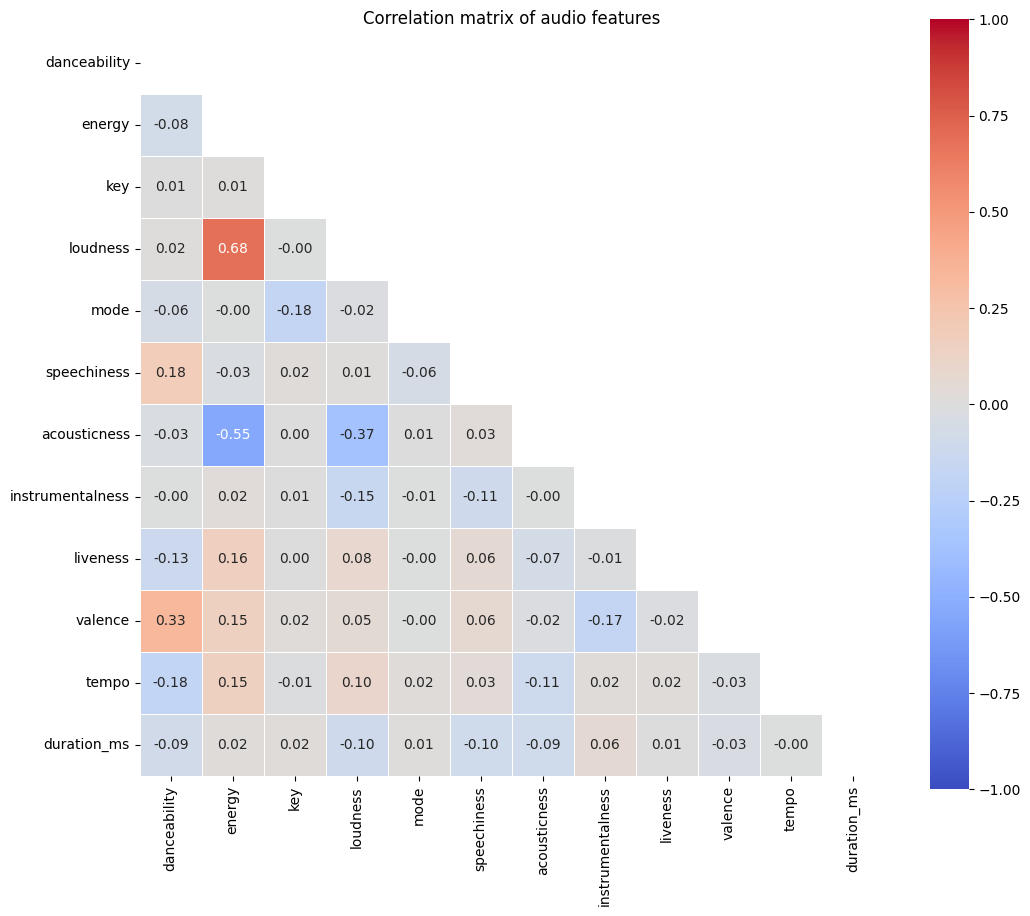

In [12]:
plt.figure(figsize=(12, 10))

correlation_matrix = df[audio_features].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Heatmap
sns.heatmap(correlation_matrix, 
            annot=True,         
            fmt=".2f",          
            cmap='coolwarm',    
            mask=mask,          
            vmax=1, vmin=-1,    
            center=0,
            square=True, 
            linewidths=.5)

plt.title('Correlation matrix of audio features')
plt.show()

Only Loudness and Energy have a strong positive relationship, and Acousticness and Energy have a strong negative relationships. Neither it's strong enough to delete one due to redundancy. It's interesting to note the week correlation between Valence and Energy, and Valence and Danceability

## Affective Mapping

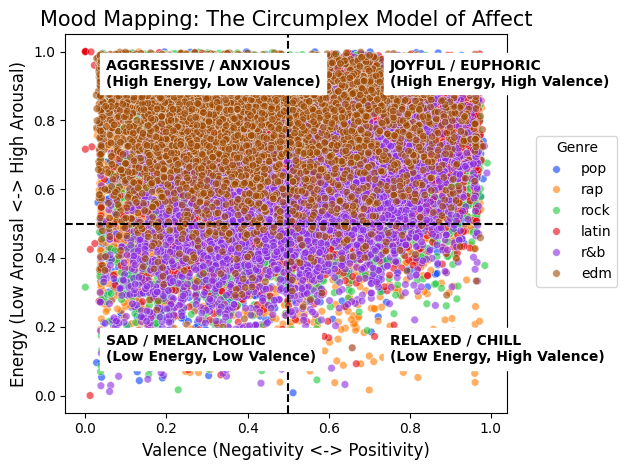

In [21]:
# We map 'playlist_genre' to color (hue) to observe if genres form distinct emotional clusters
sns.scatterplot(
    data=df, 
    x='valence', 
    y='energy', 
    hue='playlist_genre', 
    alpha=0.6, 
    palette='bright',
    s=30 
)

# Quadrant Thresholds (Based on Russell's Circumplex Model)
# We use 0.5 as the standard neutral baseline for normalized features
plt.axvline(0.5, color='black', linestyle='--', linewidth=1.5)
plt.axhline(0.5, color='black', linestyle='--', linewidth=1.5)

# Quadrant Annotations (Psychological Interpretation)
# Q1: High Arousal, Negative Valence
plt.text(0.05, 0.9, 'AGGRESSIVE / ANXIOUS\n(High Energy, Low Valence)', 
         fontsize=10, backgroundcolor='white', fontweight='bold')

# Q2: High Arousal, Positive Valence
plt.text(0.75, 0.9, 'JOYFUL / EUPHORIC\n(High Energy, High Valence)', 
         fontsize=10, backgroundcolor='white', fontweight='bold')

# Q3: Low Arousal, Negative Valence
plt.text(0.05, 0.1, 'SAD / MELANCHOLIC\n(Low Energy, Low Valence)', 
         fontsize=10, backgroundcolor='white', fontweight='bold')

# Q4: Low Arousal, Positive Valence
plt.text(0.75, 0.1, 'RELAXED / CHILL\n(Low Energy, High Valence)', 
         fontsize=10, backgroundcolor='white', fontweight='bold')

# Titles and Axis Labels
plt.title('Mood Mapping: The Circumplex Model of Affect', fontsize=15)
plt.xlabel('Valence (Negativity <-> Positivity)', fontsize=12)
plt.ylabel('Energy (Low Arousal <-> High Arousal)', fontsize=12)

plt.legend(bbox_to_anchor=(1.05, 0.75), loc='upper left', title='Genre')

plt.tight_layout()
plt.show()

### Categorize by genre 

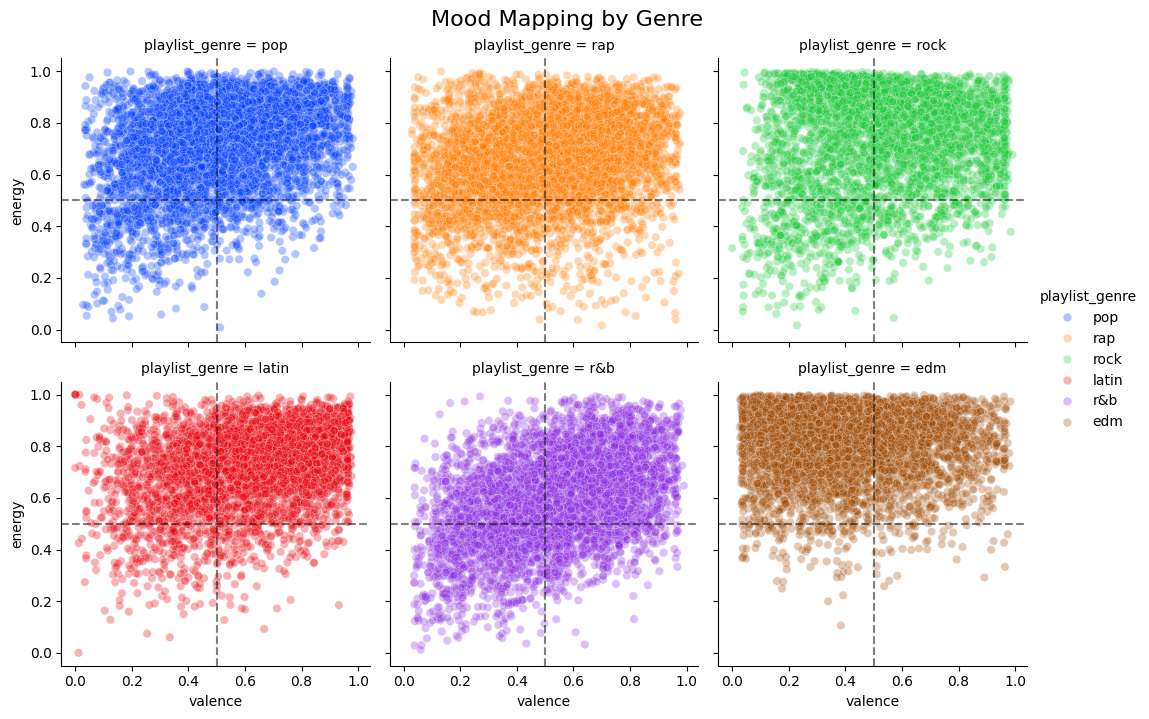

In [23]:
# 'col_wrap=3' means we will have 3 charts per row
g = sns.relplot(
    data=df, 
    x='valence', 
    y='energy', 
    hue='playlist_genre', 
    col='playlist_genre', 
    col_wrap=3, 
    height=3.5, 
    aspect=1,
    alpha=0.3,      # Adjust transparency
    palette='bright'
)

# Add the Quadrant Lines to each subplot
for ax in g.axes.flatten():
    ax.axvline(0.5, color='black', linestyle='--', alpha=0.5)
    ax.axhline(0.5, color='black', linestyle='--', alpha=0.5)

g.fig.suptitle('Mood Mapping by Genre', y=1.02, fontsize=16)
plt.show()

### Simplify using centroids

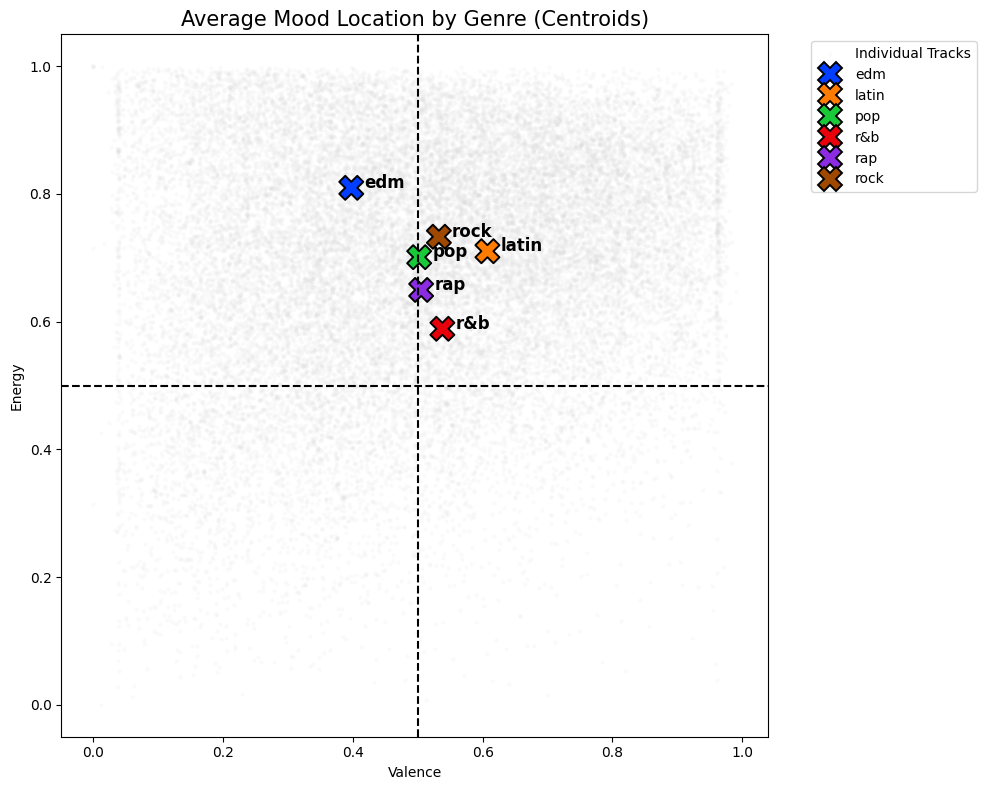

In [ ]:
# Calculate the center (mean) for each genre
genre_means = df.groupby('playlist_genre')[['valence', 'energy']].mean().reset_index()

plt.figure(figsize=(10, 8))

# Plot backgrounds points very faintly for context
sns.scatterplot(
    data=df, x='valence', y='energy', 
    color='lightgray', alpha=0.1, s=10, label='Individual Tracks'
)

# Plot the centroids
sns.scatterplot(
    data=genre_means, 
    x='valence', y='energy', 
    hue='playlist_genre', 
    s=300, 
    marker='X', 
    edgecolor='black',
    palette='bright'
)

# Add labels to the centroids
for i in range(genre_means.shape[0]):
    plt.text(
        genre_means.valence[i]+0.02, 
        genre_means.energy[i], 
        genre_means.playlist_genre[i], 
        fontsize=12, 
        weight='bold'
    )

# Quadrant Lines
plt.axvline(0.5, color='black', linestyle='--')
plt.axhline(0.5, color='black', linestyle='--')

plt.title('Average Mood Location by Genre (Centroids)', fontsize=15)
plt.xlabel('Valence')
plt.ylabel('Energy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

**Observation:**
The centroid analysis reveals a significant limitation in using broad genre labels to predict emotional states. As shown in the plot:

* **High Overlap:** Distinct genres such as *Pop*, *Rock*, *Latin*, and *Rap* cluster tightly in the **Euphoric Quadrant** (High Energy, High Valence), making them mathematically indistinguishable based on averages alone.
* **The Average Trap:** While the centroids suggest that "Rock is happy," the background scatter plot shows massive dispersion. All genres contains tracks across all four emotional quadrants.

**Conclusion for the User Profile Engine:**
Relying on **Genre Averages** to determine a user's psychological profile is **statistically invalid**. It forces a "one-size-fits-all" label that ignores the nuance of individual listening habits. E.g. an user listening to specific *Sad Rock* ballads would be misclassified as "Euphoric" if we only looked at the genre's average.

**Strategic Pivot:**
To build an accurate psychological profile, we must abandon genre-level aggregation and focus on **granular, track-level analysis** and **distribution spreads** (Variance/Standard Deviation) rather than simple means.